# Walkthrough of IB Color Naming Model

This notebook contains a walkthrough of an implementation of the color naming model from Zaslavsky, Kemp, Regier and Tishby (2018) in ULTK.

This involves several simplifying assumptions. If you want to apply the actual naming model from the paper, you should add https://github.com/nogazs/ib-color-naming/tree/master as a submodule to your project.

Imports

In [1]:
import os
import numpy as np
import pandas as pd

from ultk.effcomm import ib
from ultk.language.semantics import Universe

from tqdm import tqdm

## Construct the IB model

### Load the universe

In [2]:
# This assumes you've run the script ./scripts/read_color_universe.py
color_universe = Universe.from_csv("outputs/color_universe.csv")

# shape `(330, 3)`: L*a*b* values for each Munsell chip
cielab_points = np.array([(ref.L, ref.a, ref.b) for ref in color_universe.referents])

### Define meaning distributions in terms of distance in CIELAB space

In [3]:
def meaning_distance(
    center: np.ndarray, other_point: np.ndarray, sigma_squared: float = 64.0
) -> float:
    """Calculate the distance between two points in CIELAB space.

    Args:
        center: the first point (e.g. (L, a, b) for a Munsell chip)
        other_point: the second point
        sigma_squared: the variance of the Gaussian kernel

    Returns:
        exp(-||center - other_point||^2 / (2 * sigma_squared))
    """
    return np.exp(-np.linalg.norm(center - other_point) ** 2 / (2 * sigma_squared))

# shape: `(330, 330)`
meaning_distributions = np.array(
    [
        [meaning_distance(center, other_point) for other_point in cielab_points]
        for center in cielab_points
    ]
)
meaning_distributions /= meaning_distributions.sum(axis=1, keepdims=True)

In [4]:
pU_M = meaning_distributions

Load the prior

In [5]:
pM = np.load("data/zkrt18_prior.npy").squeeze()
# pM = np.full(pU_M.shape[0], 1/pU_M.shape[0])

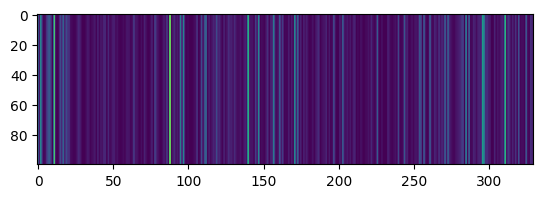

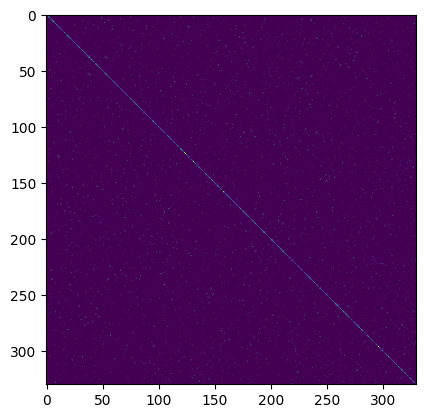

In [6]:
import matplotlib.pyplot as plt

plt.imshow(np.stack([pM]*100)); plt.show()
plt.imshow(pU_M); plt.show()

### Get IB model

In [83]:
model_fn = "./outputs/naming_model.pkl"
if os.path.exists(model_fn):
    model = ib.IBNamingModel.from_pickle("./outputs/naming_model.pkl")
else:
    # This takes hours, but will work
    model = ib.get_ib_naming_model(
        pU_M,
        pM,
        # add custom beta values here
        betas=np.logspace(0, 5, 1600,)
    )

beta=441.98077:  47%|████▋     | 753/1600 [54:50:36<61:41:23, 262.20s/it]    


KeyboardInterrupt: 

## Load natural languages

In [8]:
# Read the data
term_df = pd.read_csv(
    "data/term.txt", delimiter="\t", names=("lang", "spkr", "cnum", "term")
)

# Get the number of unique meanings and initialize variables
num_m = len(term_df.cnum.unique())

# Create a dictionary to store p(W|C) for each language
pW_C_dict = {}

# Process each language separately
for lang in tqdm(term_df.lang.unique()):
    # Subset the data for this language
    lang_df = term_df[term_df.lang == lang]
    
    # Map terms and categories to indices
    unique_terms = lang_df.term.unique()
    term_to_idx = {term: i for i, term in enumerate(unique_terms)}
    num_w = len(unique_terms)
    
    # Initialize p(W|C) matrix
    pW_C = np.zeros((num_m, num_w))
    
    # Populate the matrix
    for cnum, group in lang_df.groupby('cnum'):
        c_idx = cnum - 1  # Assuming cnum starts from 1
        term_counts = group['term'].value_counts()
        
        for term, count in term_counts.items():
            t_idx = term_to_idx[term]
            pW_C[c_idx, t_idx] = count
    
    # Normalize rows to get probabilities
    pW_C = pW_C / pW_C.sum(axis=1, keepdims=True)
    
    # Store the result for this language
    pW_C_dict[lang] = pW_C


 23%|██▎       | 25/110 [00:02<00:07, 11.93it/s]/var/folders/3z/q1pyp9n929z2nh_1_69s7y_40000gn/T/ipykernel_44608/2338820042.py:35: RuntimeWarning: invalid value encountered in divide
  pW_C = pW_C / pW_C.sum(axis=1, keepdims=True)
100%|██████████| 110/110 [00:06<00:00, 18.24it/s]


In [9]:
# langq = lambda lang: language_to_encoder(lang)
get_point = lambda q: (model.complexity(q), model.accuracy(q), model.d_IB(q))

df_langs = pd.DataFrame.from_records(
    [
        (key, )
        + get_point(q)
        for key, q in tqdm(pW_C_dict.items())
    ],
    columns=("language", "complexity", "accuracy", "distortion"),
)
df_langs

100%|██████████| 110/110 [00:00<00:00, 396.63it/s]


,language,complexity,accuracy,distortion
0,1,1.530107,1.352481,3.018719
1,2,2.010779,1.739755,2.631445
2,3,2.169118,1.853011,2.518189
3,4,1.896720,1.677120,2.694080
4,5,2.347642,2.107826,2.263375
...,...,...,...,...
105,106,2.536911,2.304622,2.066578
106,107,1.721931,1.545429,2.825771
107,108,2.042612,1.865361,2.505839
108,109,2.087564,1.872844,2.498356


## Plot

In [10]:
import plotnine as pn

In [11]:
df_bound = pd.DataFrame(model.IB_curve.T, columns=["complexity", "accuracy"],)
df_bound

,complexity,accuracy
0,5.048406e-12,4.696687e-12
1,1.975812e-05,1.959520e-05
2,2.043617e-05,2.026769e-05
3,2.112669e-05,2.095256e-05
4,2.182940e-05,2.164951e-05
...,...,...
1496,7.412368e+00,4.371200e+00
1497,7.412368e+00,4.371200e+00
1498,7.412368e+00,4.371200e+00
1499,7.412368e+00,4.371200e+00


/Users/nathanielimel/miniforge3/envs/ultk/lib/python3.11/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_point : Removed 1 rows containing missing values.


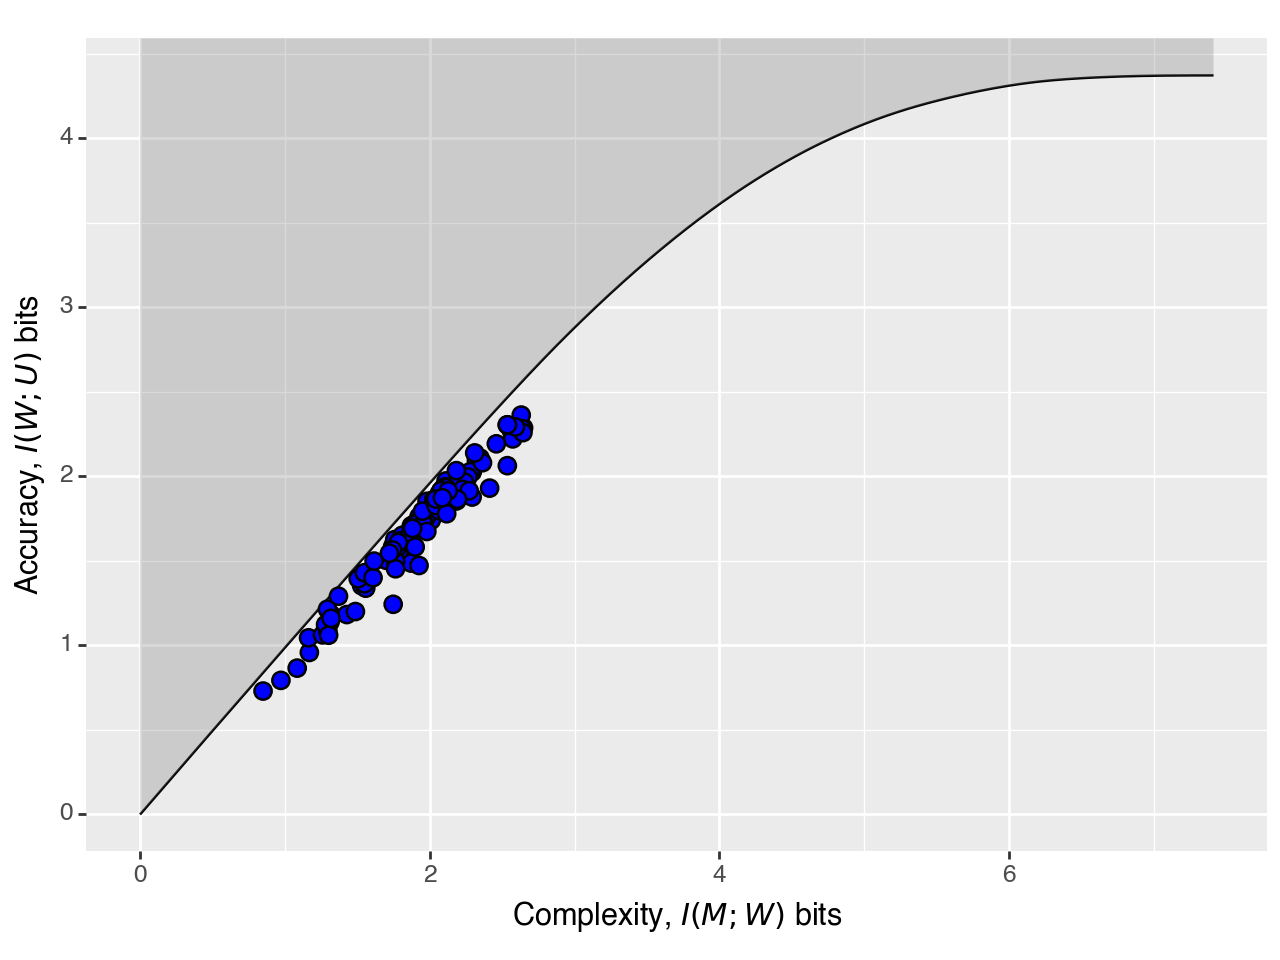

<Figure Size: (640 x 480)>

In [ ]:
(
    pn.ggplot(
        df_bound, 
        mapping=pn.aes(x="complexity", y="accuracy"),
    )  
    + pn.geom_line() # IB curve
    + pn.geom_ribbon(
    mapping=pn.aes(
        x="complexity",
        ymin="accuracy",
        ymax=np.inf,
        ),
        fill="gray",
        alpha=0.3,
    )
    # natural langs
    + pn.geom_point( 
        data=df_langs,
        # alpha=0.3,
        size=3,
        fill="blue",
    )
    + pn.xlab("Complexity, $I(M;W)$ bits")
    + pn.ylab("Accuracy, $I(W;U)$ bits")
)

### Comparison with ultk measures

WIP

In [41]:
# BUG: Unfortunately, the dict.txt of term  names is not consistent with the number of terms observed per lang in term.txt
expressions_df = pd.read_csv(
    "data/dict.txt", delimiter="\t", 
)
expressions_df

,LNUM,TNUM,TRAN,WCSC,COLOR
0,1,1,lobu,LB,NaN
1,1,2,lofu,LF,NaN
2,1,3,lebe,LE,NaN
3,1,4,fwae,F,NaN
4,1,5,wãwanakoko,WK,NaN
...,...,...,...,...,...
2358,110,12,chicul,CH,NaN
2359,110,13,nu-rial,RI,NaN
2360,110,14,nu-ryal,RI,NaN
2361,110,15,canel,CA,NaN


In [59]:
from ultk.language.language import Language, Expression, Meaning
from ultk.util.frozendict import FrozenDict

In [ ]:
def encoder_to_language(qW_M: np.ndarray, words: list[str] = None, name: str = None, natural: bool = False) -> Language:
    """Minimal mapping from encoder to language using Bayesian decoder with dummy forms. Once this is cleaned up we can add to the ultk.effcomm.ib module."""

    if words is None:
        words = range(qW_M.shape[1])

    return Language(
        expressions=tuple([
            Expression(
                form=str(words[i]),
                meaning=Meaning[float](
                    FrozenDict({
                        # define each mapping from referent -> probability
                        color_universe.referents[chip_num]: qm[chip_num]
                        for chip_num in range(qW_M.shape[0])
                    }), 
                    color_universe, 
                )
            )
        for i, qm in enumerate(model.m_hat(qW_M))
        ]),
        name=name,
        natural=natural,
    )

In [75]:
natural_languages = [encoder_to_language(q, name=key, natural=True) for key, q in tqdm(pW_C_dict.items())]

# Takes about a minute
optimal_languages = [encoder_to_language(q, name=model.betas[i]) for i, q in tqdm(enumerate(model.qW_M), total=len(model.qW_M))]

100%|██████████| 1501/1501 [01:40<00:00, 14.87it/s]


In [72]:
from ultk.effcomm.informativity import informativity

similarity = lambda ref, ref_: meaning_distance(center=np.array([ref.L, ref.a, ref.b]), other_point=np.array([ref_.L, ref.a, ref.b]))

get_inf = lambda lang: informativity(lang, pM, similarity)

In [77]:
# Takes about a minute
df_langs["ultk_inf"] = [get_inf(lang) for lang in tqdm(natural_languages)]

# Takes 20-ish mins :/
df_bound["ultk_inf"] = [get_inf(lang) for lang in tqdm(optimal_languages)]

100%|██████████| 1501/1501 [20:12<00:00,  1.24it/s]


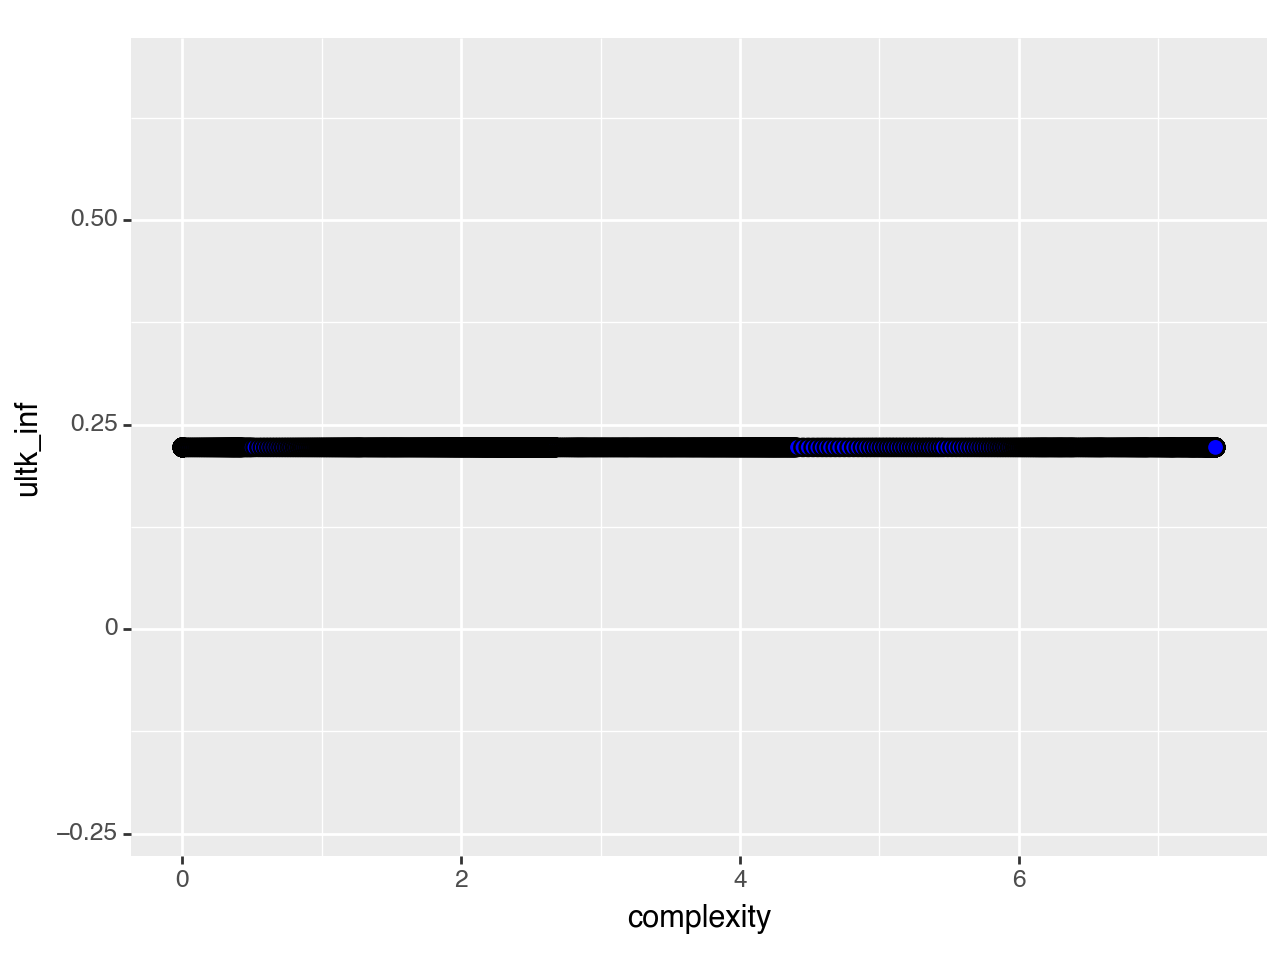

<Figure Size: (640 x 480)>

In [79]:
(
    pn.ggplot(
        df_bound, 
        mapping=pn.aes(x="complexity", y="ultk_inf"),
    )  
    # optima
    + pn.geom_line()
    # natural langs
    + pn.geom_point( 
        # data=df_langs,
        # alpha=0.3,
        size=3,
        fill="blue",
    )
)